# Reinforcement learning (STDP)

### The state of each synapse is represented by two variables:
   - synaptic strength/weight, s
   - activation of an enzyme important for plasticity, c (relatively slow process acting as a synaptic tag)
    
#### The dynamics of these variables follow: 
      dc/dt = - c/τ-c + STDP (τ)δ( t − t pre / post ),
      ds/dt = cd

   - where τ = t post − t pre , d describes the extracellular concentration of DA and δ( t ) is the Dirac delta     function.
   - Firings of pre- and postsynaptic neurons change c by the amount STDP (τ).
   - Variable c decays to 0 exponentially with the time constant τ-c = 1s (eligibility trace).
   - The model integrates the millisecond timescale of spike interactions in STDP with the slow trace modulated by   global reward signal (behavioral timescale).
   
#### The variable d describes the concentration ( μM) of extracellular DA:
      dd/dt = − d/τ-d + + DA(t), 
      
   - where τ-d is the time constant of DA uptake and DA(t) models the source of DA due to the activity of   dopaminergic neurons -50 (reward minus expected reward).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [2]:
def neural_network(I_init, gl, Cm, num):
    ######### Constants
    U_rest      =   -0.065              #restint membrane potential [U]
    U_reset     =   -0.065
    thresh  =   -0.050                  #spiking threshold [U]
    tau =  Cm/gl
    A_plus = 2                          #amplitude parameter A ± ( w ) ,we consider this constant!
    A_neg = -1.5
    tau_plus = 0.0002
    tau_neg =  0.0002                  #tau for stdp rule
    tau_c = 0.01
    tau_d = 0.002
  

    ######### Setup
    # TIME
    T       =   0.200                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    #Two different time patterns
    tp =[[4,90,90,4,150,10000,10000,10000,10000,10000],[10000,10000,10000,10000,10000,100,15,100,15,15]]
    
    
    # VOLTAGE
    U_inp       =   np.zeros((10,len(time)))   # array for saving Voltage history - input layer
    U_inp[:,0]  =   U_rest                     # set initial to resting potential - outer layer
    U_out       =   np.zeros((2,len(time)),dtype = np.float64) #outer layer
    U_out[:,0]  =   U_rest
    
    # CURRENT
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((10,len(time)))
    I_out       =   np.zeros((2,len(time)))
    I_out[0,:]  = 0.0003
    I_out[1,:]  = 0.0003
    
    

    ######### Measurements
    spikes = [[0] for i in range(10)]         #save the time of neuron's spike - input layer neurons 
    spikes_out = [[0],[0]]                    #output layer neurons - spike time
    mark = np.zeros((10,len(time)))
    mark_out = np.zeros((2,len(time)))
    c1 = np.zeros((10,len(time)))             #save the changing of synapse weight [∆ w]
    c2 = np.zeros((10,len(time)))
    d1 = np.zeros((10,len(time)))
    d2 = np.zeros((10,len(time)))
    s1 = np.zeros((10,len(time)))
    s2 = np.zeros((10,len(time)))

    STDP_t = [[0],[0]]                        #save the |∆ t | = | t-post − t-pre | 
    
    s1[:,0] = abs(np.random.normal(3,1,size=(10)))/10 #set weights for the connection
    s2[:,0] = abs(np.random.normal(4,1,size=(10)))/10
    cnt = 0
    
    ######### Simulation
    for i in range(1,len(time)):
           
        if(i%500==0): cnt = randint(0,500)%2
        #input layer neurons
        for j in range(10):
            STDP1 , STDP2, DA1, DA2 = 0, 0, 0, 0 
            
            if(i% 500 == 0):  U_inp[j][i-1] = U_rest
            #compute current
            I[j][i]= I[j][i] + I_init[i]*bool(i%500 > tp[cnt][j])
            
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U_inp[j][i] = (((U_rest - U_inp[j][i-1]) + I[j][i]/gl)*dt)/tau + U_inp[j][i-1]
                    
            # use " dc/dt = - c/τ-c + STDP (τ)δ( t − (t-pre / post) )" to get this equation
            if (U_inp[j][i] > thresh):STDP1, STDP2 = STDP(spikes_out,time[i], tau_neg, STDP_t, A_neg)
            c1[j][i] =(-c1[j][i-1]/tau_c + STDP1)*dt+c1[j][i-1]
            c2[j][i] =(-c2[j][i-1]/tau_c + STDP2)*dt+c2[j][i-1]
            
            # use " dd/dt = − d/τ-d + + DA(t)" to get this equation
            if mark[j][i] == 1 : DA1 , DA2 = DA(spikes_out,spikes[j][-1],A_neg)
    
            d1[j][i] = (-d1[j][i-1]/tau_d + DA1)*dt + d1[j][i-1]
            d2[j][i] = (-d2[j][i-1]/tau_d + DA2)*dt + d2[j][i-1]
            
            # use " ds/dt = cd" to get this equation
            s1[j][i] = c1[j][i]*d1[j][i]*dt*1000*bool(c1[j][i]*d1[j][i]*0.02+s1[j][i-1]>0) + s1[j][i-1] 
            s2[j][i] = c2[j][i]*d2[j][i]*dt*1000*bool(c2[j][i]*d2[j][i]*0.02+s2[j][i-1]>0) + s2[j][i-1]
            
            # in case we exceed threshold               
            if U_inp[j][i] > thresh :
                U_inp[j][i-1] = 0.04         # set the last step to spike value
                U_inp[j][i] = U_reset        # current step is resting membrane potential
                spikes[j].append(time[i])    # count spike
                mark[j][i+5+j] = 1  
                if(i< 9996):
                    add_amount = I_values(j,i,I_init,time,spikes,s1[j][i],s2[j][i])
                    I_out[:,i+1:i+3] = I_out[:,i+1:i+3] + add_amount
                 
            
                
        #output layer neurons        
        for l in range(2):
            
            STDP1 , STDP2, DA1, DA2 = 0, 0, 0, 0 
            U_out[l,i] = (((U_rest - U_out[l,i-1]) + I_out[l,i]/gl)*dt)/tau + U_out[l,i-1]
            
            if (mark_out[l][i] == 2):
                
                for j in range(10):
                    DA1 , DA2 = DA(spikes_out,spikes[j][-1],A_plus)
                    if(l==1):d1[j][i] = (-d1[j][i-1]/tau_d + DA1)*dt + d1[j][i]
                    if(l==2):d2[j][i] = (-d2[j][i-1]/tau_d + DA2)*dt + d2[j][i]
                    
                
            if U_out[l][i] > thresh:
                
                U_out[l][i-1] = 0.04         # set the last step to spike value
                U_out[l][i] = U_reset        # current step is resting membrane potential 
                spikes_out[l].append(time[i])
                mark_out[l][i+7+j] = 2
                
                for j in range(10):
                    # use " dc/dt = - c/τ-c + STDP (τ)δ( t − (t-pre / post) )" to get this equation
                    STDP1, STDP2 = STDP(spikes_out,spikes[j][-1], tau_plus, STDP_t, A_plus)
                    if(l==1):
                        c1[j][i]=(-c1[j][i-1]/tau_c+STDP1)*dt+c1[j][i]
                        s1[j][i] = c1[j][i]*d1[j][i]*dt*1000*bool(c1[j][i]*d1[j][i]*0.02+s1[j][i]>0)+s1[j][i]
                        
                    if(l==2):    
                        c2[j][i]=(-c2[j][i-1]/tau_c+STDP2)*dt+c2[j][i]
                        s2[j][i] = c2[j][i]*d2[j][i]*dt*1000*bool(c2[j][i]*d2[j][i]*0.02+s2[j][i]>0)+s2[j][i] 
                    
                    
                    
                
    return  spikes, U_out, s1, c1, d1 , s2, c2, d2

#compute the initial current
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:10000] = I_init
    return I0


#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, s1=None, s2=None, tau_I=0.001):
    #use w_ji*epsilon(s) where epsilon(s) = (s/tau).exp(1-(s/tau)) ;s=t - t_spike > 0
    exp1= (time[i+1:i+3] - spikes[j][-1])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    W = np.array([s1, s2])
    I_inp = np.dot(W.reshape(2,1),exp3.reshape(1,2))
    return I_inp


#compute STDP:use  "∆ w + = A + ( w ) · exp(−|∆ t |/τ + ) at t-post" to get this equation
def STDP(t_post=None, t_pre=0, tau_t=0.005, STDP_t=None, A = 1, amount1=0, amount2=0):
    if( len(t_post[0]) != 1 ):
        amount1 = A*math.exp(-1*abs(t_post[0][-1] - t_pre)/tau_t)*9000
        STDP_t[0].append(amount1)
    
    if( len(t_post[1]) != 1 ):
        amount2 = A*math.exp(-1*abs(t_post[1][-1] - t_pre))*10000
        STDP_t[1].append(amount2)
    return amount1,amount2
                     
def DA(t_post=None, t_pre=0,A=1,tau_t=0.00005,D1 = 0 ,D2 = 0):
    if(t_post[0][-1] - t_pre < 0 ):
        D1 = A*math.exp(-1*abs(t_post[0][-1] - t_pre))/tau_t*10
        #D1=-100000               
    elif(t_post[0][-1] - t_pre >0 and abs(t_post[0][-1] - t_pre < 0.07)):
        D1 = A*math.exp(-1*abs(t_post[0][-1] - t_pre))/tau_t*10
        #D1=150000
    if(t_post[1][-1] - t_pre < 0 ):                              
        D2 = -A*math.exp(-1*abs(t_post[1][-1] - t_pre))/tau_t*10
        #D2= -100000
    elif(t_post[1][-1] - t_pre >0 and abs(t_post[1][-1] - t_pre < 0.07)):  
        D2 = A*math.exp(-1*abs(t_post[1][-1] - t_pre))/tau_t*10
        #D2= 150000
    return  D1,D2   
                               

In [3]:
def simul_STDP(I_init ,gl_init ,Cm_init, num):
    
    # TIME
    T       =   0.200                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    
    spike, U_out, s1 , c1 , d1 , s2 , c2, d2 = neural_network(I_init, gl_init, Cm_init, num)
     

    
    for i in range(len(spike)): spike[i].pop(0)
    
    ###ploting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("input layer neurons", figsize=(14, 4))
    colors1 = ['C{}'.format(i) for i in range(10)]
    plt.title("spike raster plot")
    plt.eventplot(spike, color=colors1)
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    
    fig = plt.figure("Potential U for output layer neurons", figsize=(14, 6))
    plt.title("Potential U for output layer neurons")
    plt.plot(time, U_out[0][:], label="Potential:U")[0]
    plt.plot(time, U_out[1][:], label="Potential:U")[0]
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    
    fig = plt.figure("Reinforcement learning", figsize=(16, 16))
    plt.subplot(231)
    plt.title("weight")
    for i in range(10):
        plt.plot(time, s1[i][:], label="Potential:U")[0]
    
    plt.subplot(232)
    plt.title("dopaminergic neurons")
    plt.plot(time, d1[i][:], label="Dopamine")[0]
    
    plt.subplot(233)
    plt.title("eligibility trace")
    plt.plot(time, c1[i][:], label="plasticity")[0]
    
    plt.subplot(234)
    plt.title("weight")
    for i in range(10):
        plt.plot(time, s2[i][:], label="Potential:U")[0]
        print(s1[i][-1],s2[i][-1])
    
    plt.subplot(235)
    plt.title("dopaminergic neurons")
    plt.plot(time, d2[i][:], label="Dopamine")[0]
    
    plt.subplot(236)
    plt.title("eligibility trace")
    plt.plot(time, c2[i][:], label="plasticity")[0]         
    
                        

109.01595766247829 2.429314172970271e-10
0.25825424636240657 9.441645008709082e-12
0.2782663100357582 1.3381787442593583e-10
108.99442983703365 7.691492137010794e-12
0.23546483594566545 4.354245843620909e-12
0.14416964823526543 2.2361603285445103e-14
0.2439341576316898 26.710855424361426
4.801220474067239e-17 1.0516511593286785e-13
0.42977648534423174 26.61785442008901
0.3884194681644316 26.515741255263773


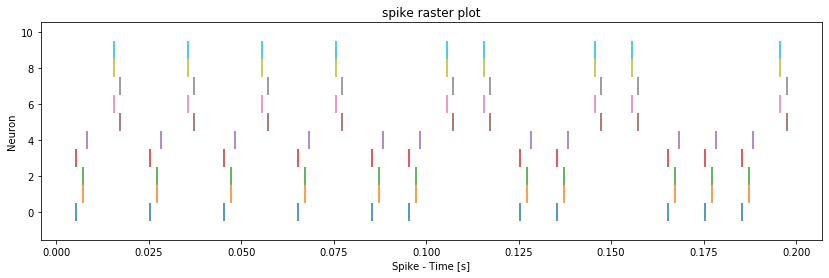

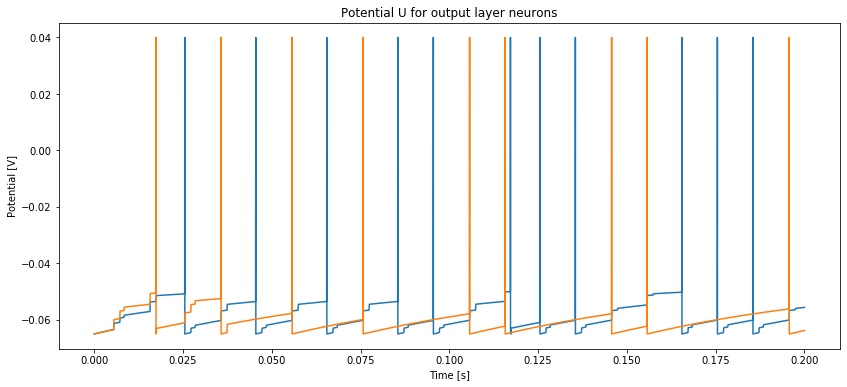

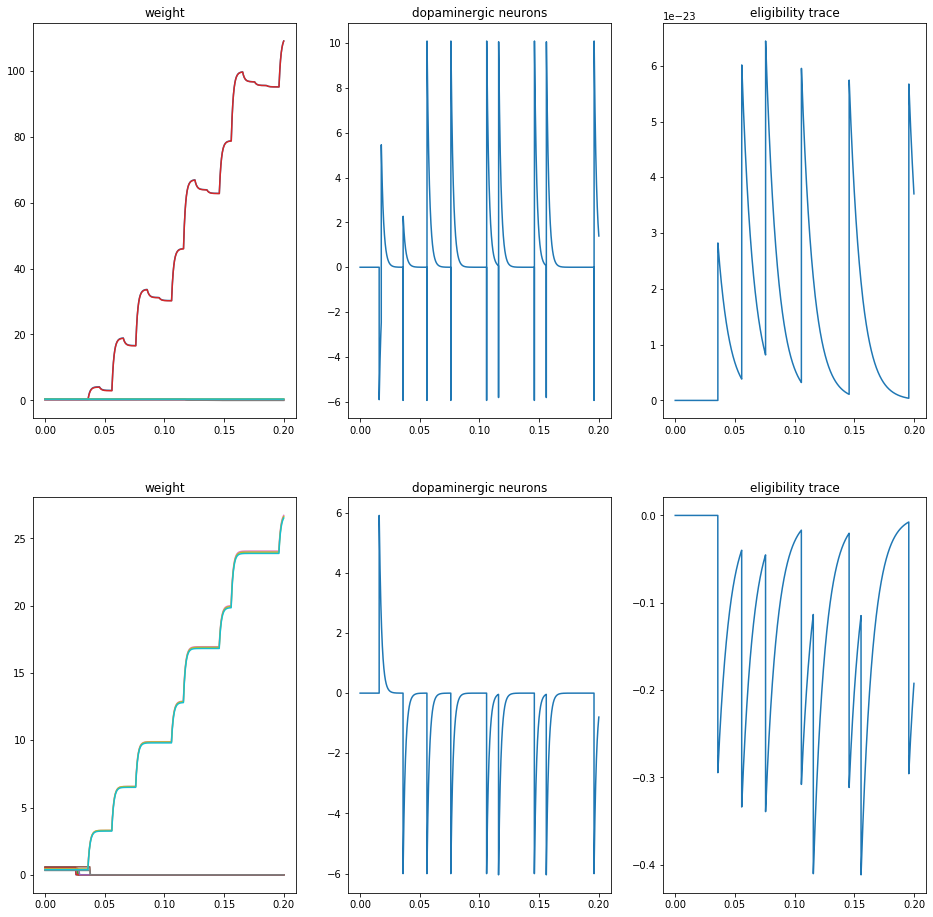

In [44]:
simul_STDP(0.0029 ,0.016,0.001 ,1)              

5.440390865444231 9.05557219427331e-19
0.27334173586532257 8.909024946600387e-19
0.3952154539396668 5.085720772796326e-19
5.536203352193795 1.064491885386282e-18
0.34532957462425573 5.1154802431249565e-18
0.838427174325487 41.990868333346704
143.6884183176336 7.194615574606678e-14
0.8692628062839387 41.76441107226154
143.48025784770144 8.582511359143398e-14
143.06877295216896 4.559180234605854e-14


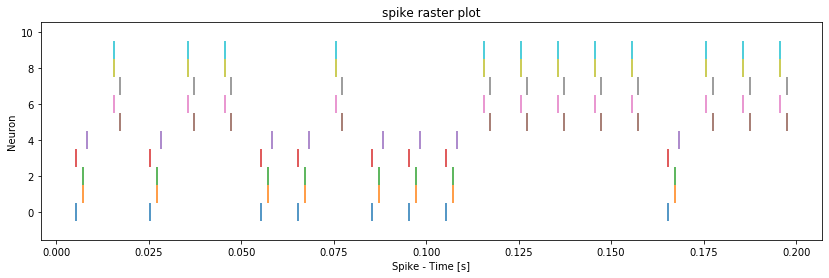

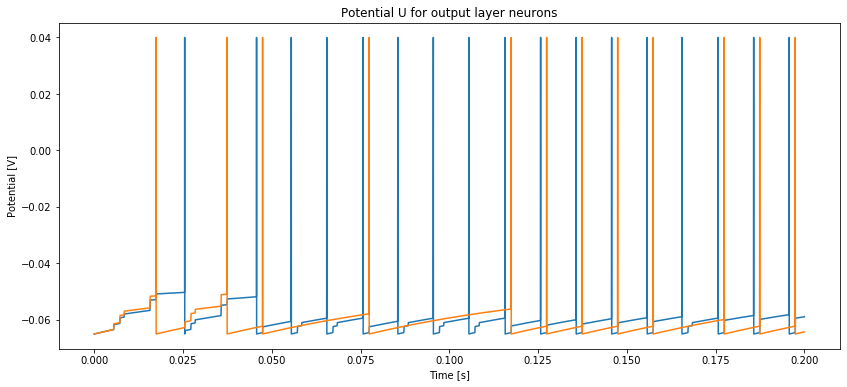

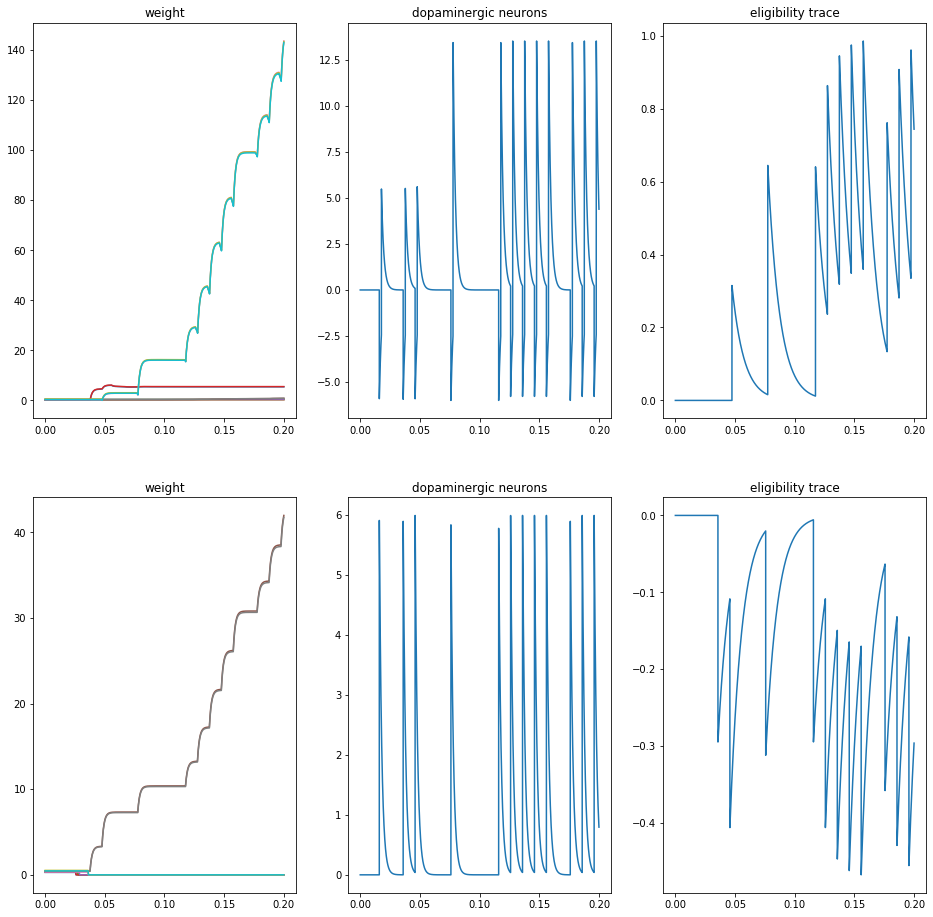

In [47]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.13537909370142673 2.2824328451087403e-16
0.14548517497547994 19.841275086783376
0.18447900764981956 19.77546224022856
0.30336753738597555 2.1528356082280556e-18
0.21736879684094124 1.9957445269370854e-18
32.41500718746582 1.5370717676874025e-10
5.5974416454514895 8.335313985420037e-11
32.373975739752765 3.4460189190444085e-10
5.602885812768387 2.5117284690324067e-11
5.715145725356523 5.059467767552662e-11


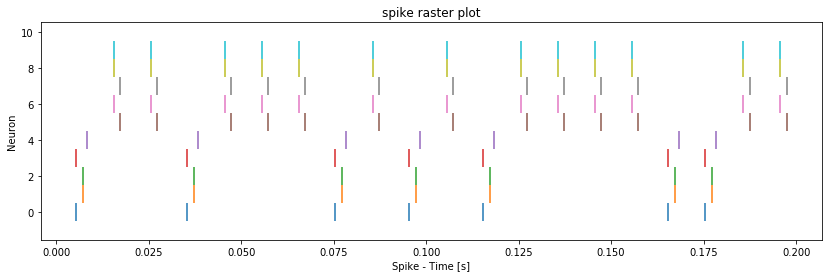

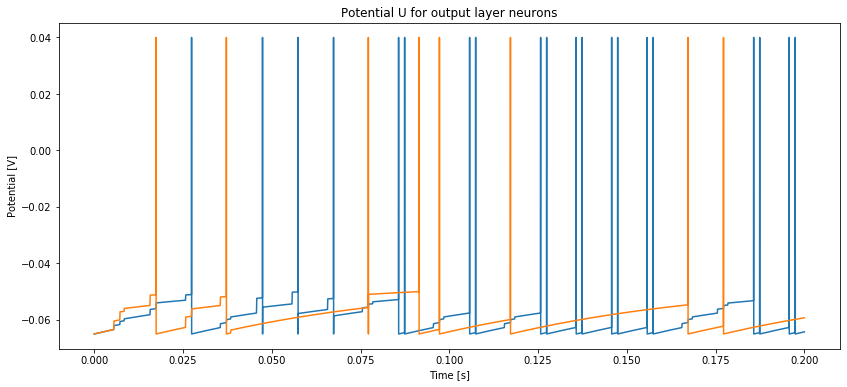

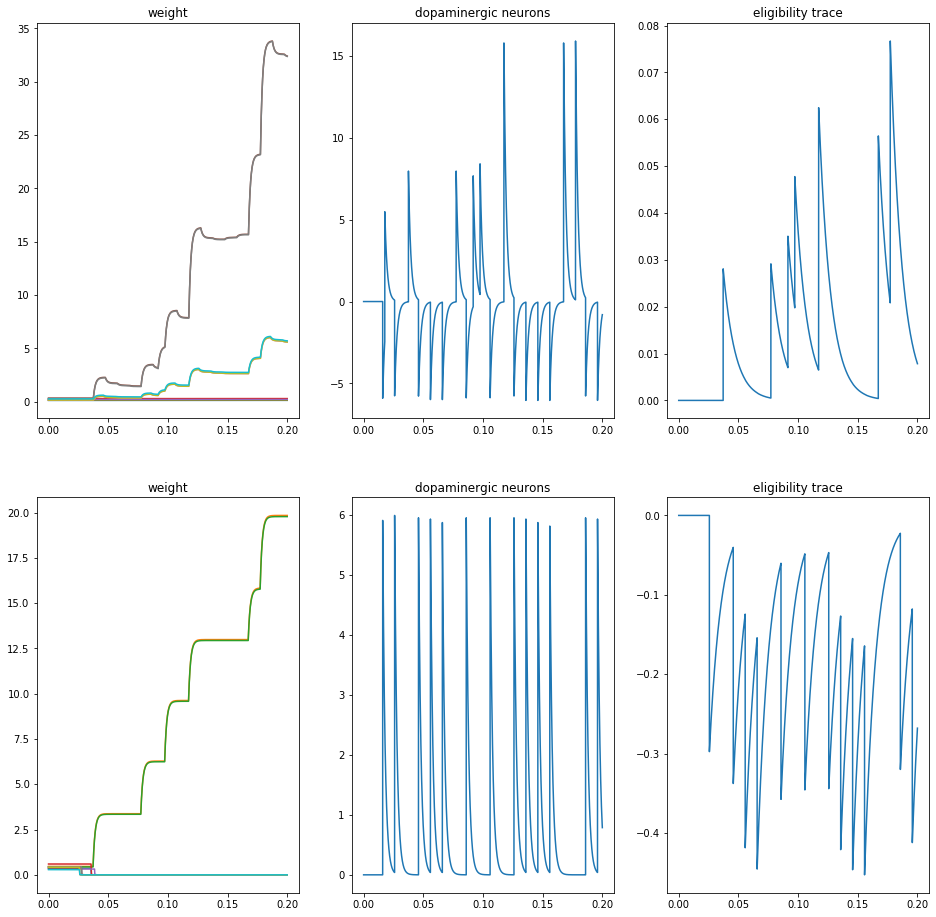

In [15]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.6378024527641565 2.840213137406508e-11
65.69442226039573 27.8279047447901
65.72540926681266 27.765248099441486
0.5566677603205311 4.0840825069279985e-11
1.1383802655220388e-11 6.48392460581098e-12
0.38966341146080336 1.2574956219057031e-10
13.428670608937987 6.175198641688157e-12
0.410499791288902 1.3831945247140497e-10
13.516876040702146 9.427703646553733e-11
13.539338273162345 3.7773645396587576e-11


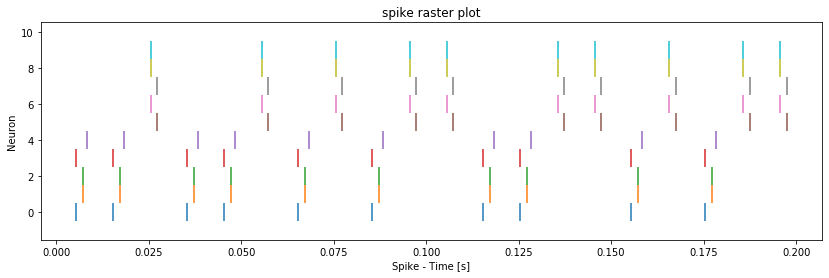

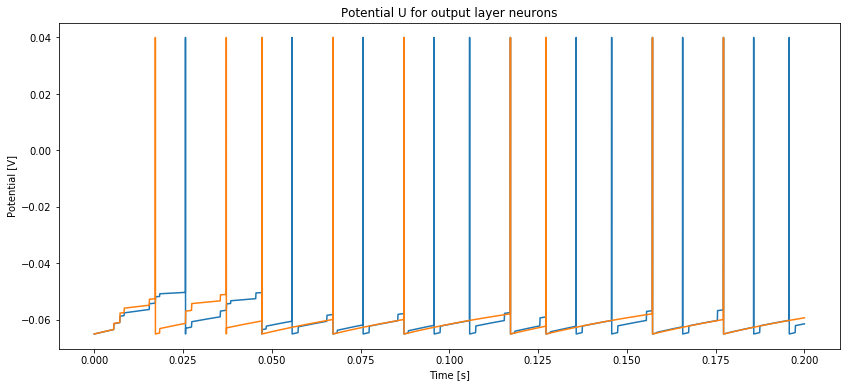

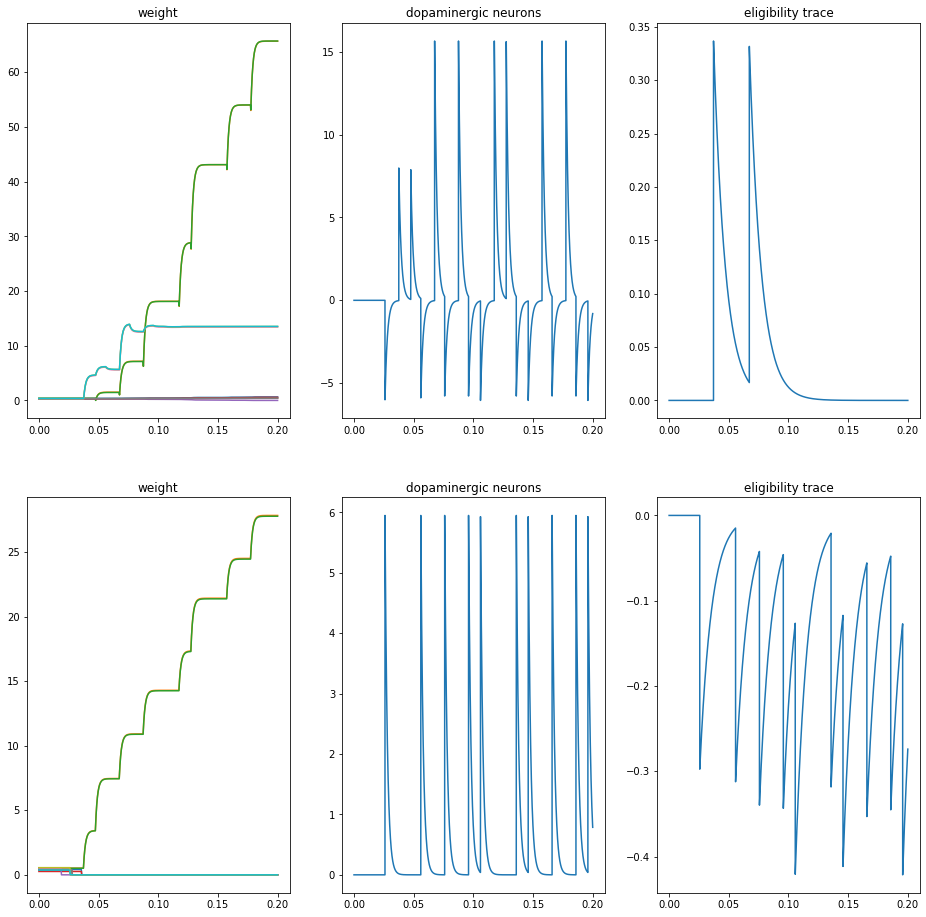

In [50]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.16487222735153995 1.92348921285179e-15
0.2845781724749227 19.001612103153953
0.09309682076818745 18.887693583578077
0.24201234264218285 5.86488159177447e-16
0.1691084094311292 1.6269974223851015e-15
0.6597476116872651 4.3550137630317096e-11
65.28380252758909 2.054356231371325e-11
0.6726856770926631 4.1828227078080257e-11
65.22500560210948 1.5700883924150998e-10
65.39841157741786 1.8481713690156368e-10


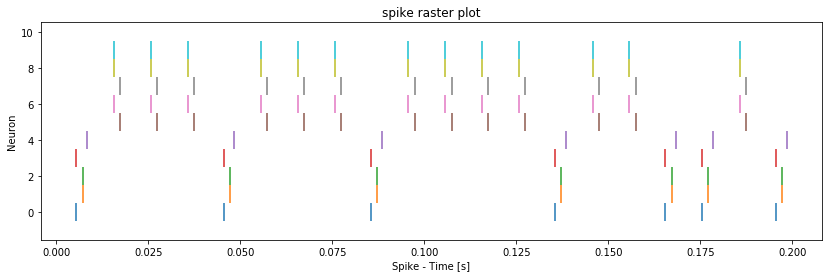

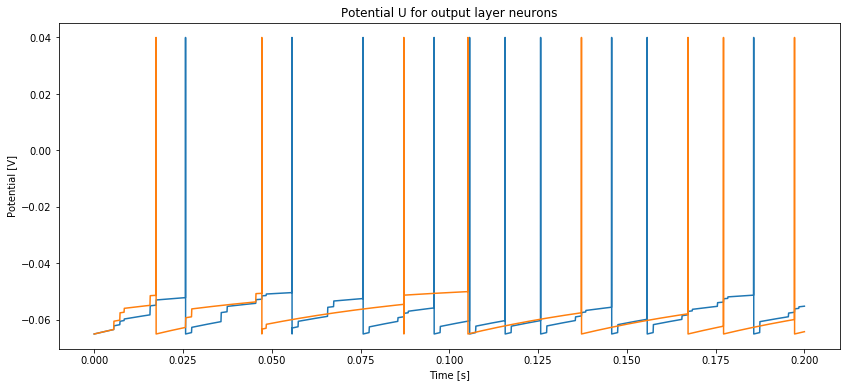

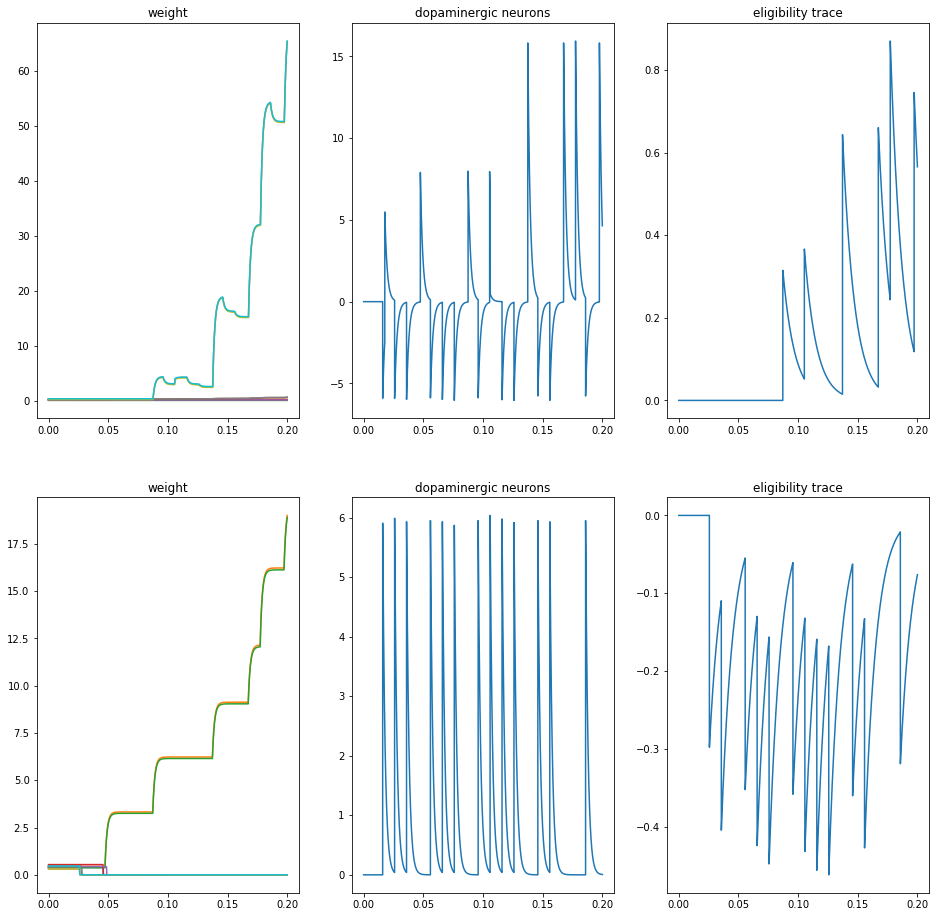

In [49]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

3.223926468136268 1.631679776624424e-14
14.415424412991525 4.594388000449069e-14
14.420135082110196 2.9797970682778964e-14
3.0628911461641435 2.960157325117771e-14
0.3501017497228093 9.058558381502083e-14
72.06243533135564 36.89694921541797
0.3505317579619033 3.15400632042747e-11
72.22234901734379 36.85955129012971
0.3279852615580108 1.3653037357610976e-11
0.40679239038366594 2.1417409533385303e-11


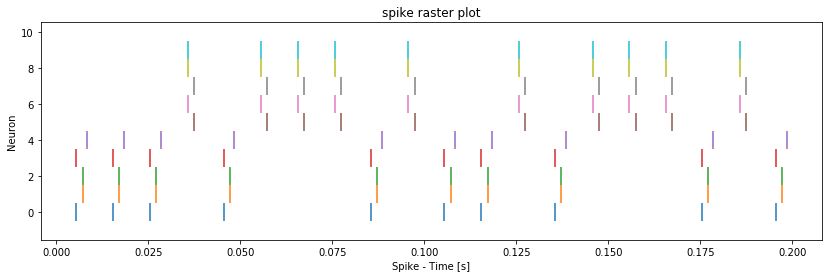

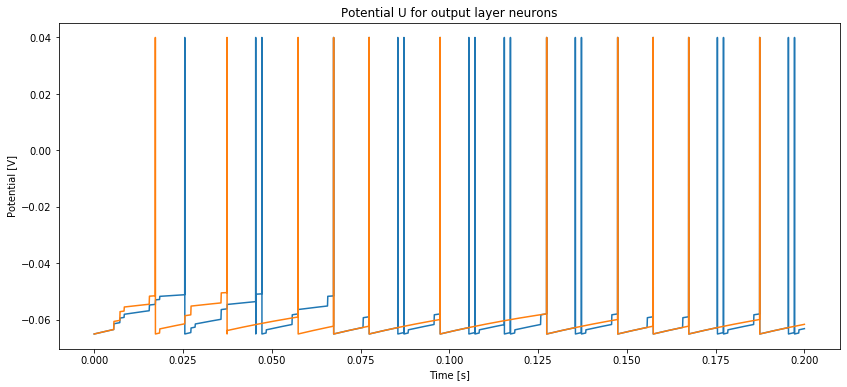

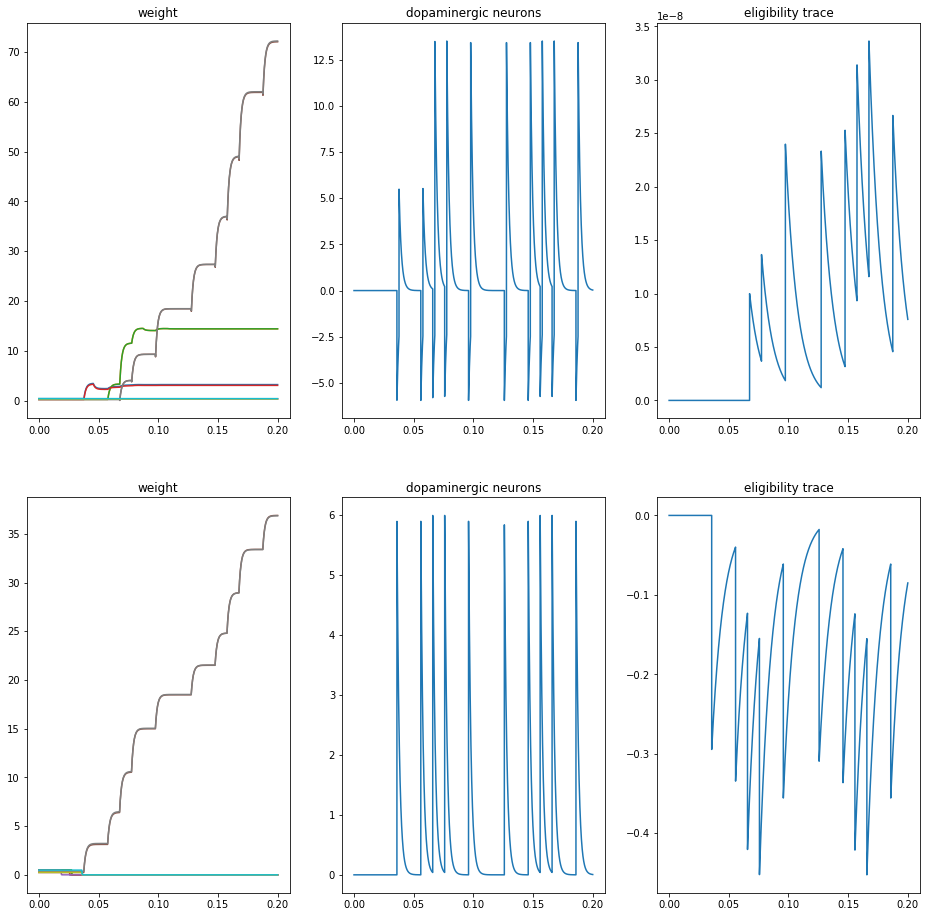

In [54]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

25.250888071684468 21.88595084788795
0.1873995150165901 1.0167136576911353e-18
0.03200361799847218 5.25204965107468e-20
25.15251248543288 21.778658244853627
0.39711545473495535 1.826298197726638e-19
50.113879243425835 2.1183179090273159e-13
1.9747030951584883 2.1054134568942915e-15
49.90733175798633 9.745831481298208e-14
1.892641733829766 1.1191333265779454e-13
1.964140949755936 2.329523856451944e-14


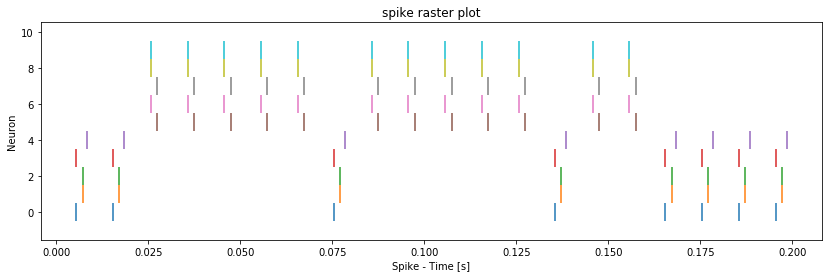

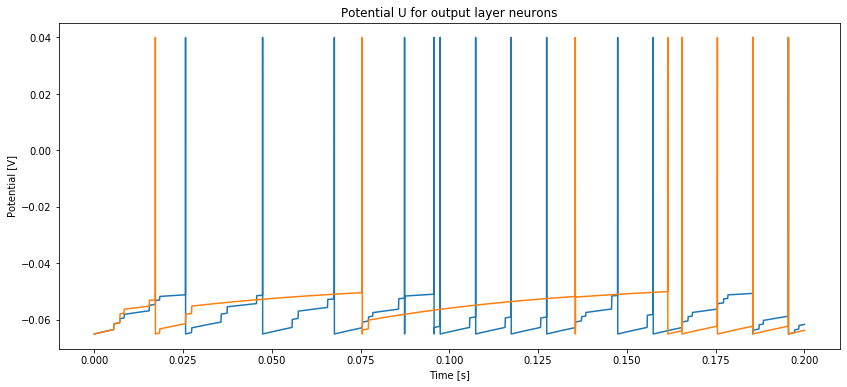

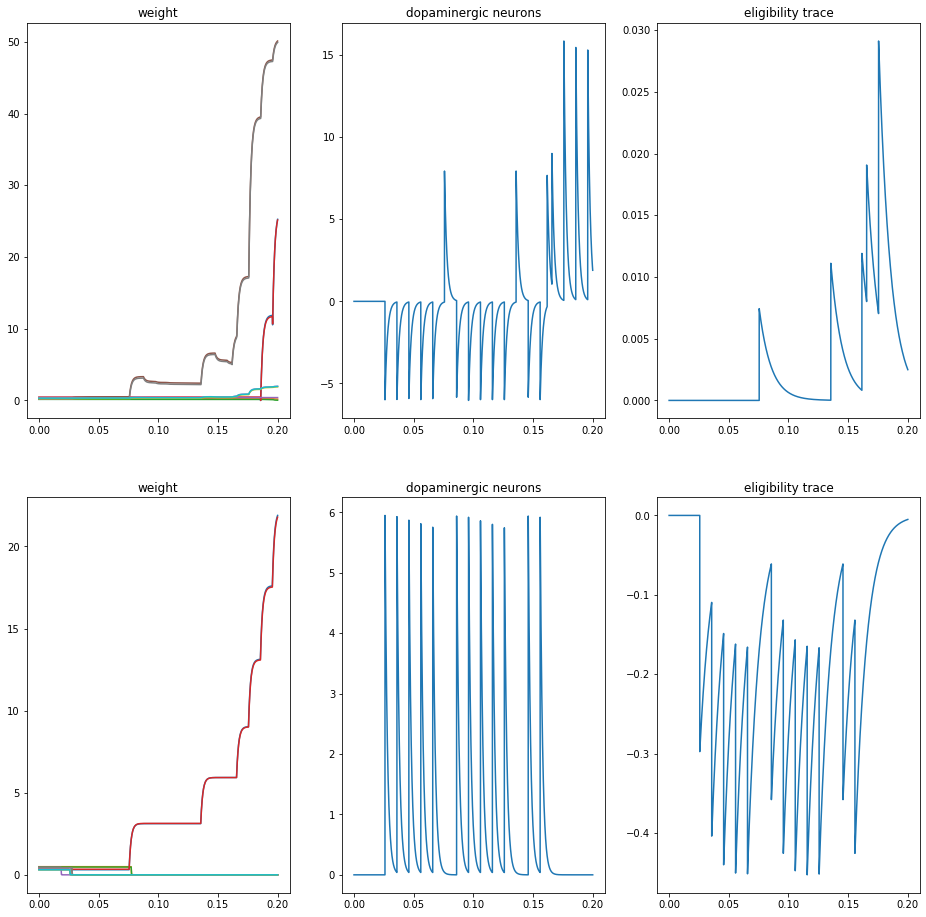

In [58]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

1.3253512831675227 2.1987075566905484e-11
35.68704930939388 1.1896176261357532e-11
35.869730407089236 3.249060777273781e-11
1.4429289054928207 7.078235806657306e-11
6.430697122562732 3.684893619355653e-11
39.49113506408019 23.46792124689051
1.9332980284424548 2.890369259556938e-23
39.564604440425065 23.44545021655057
1.811780765785202 6.990372356502239e-25
1.9785996284574836 2.4331088580672454e-24


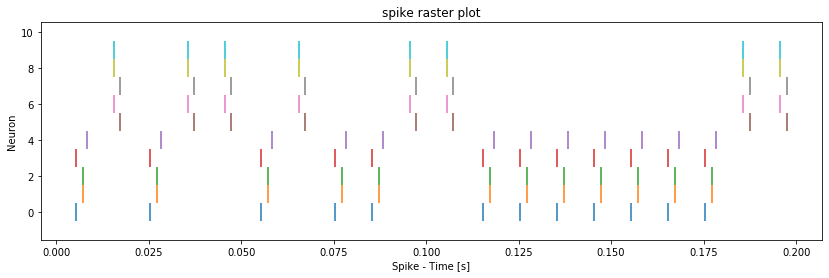

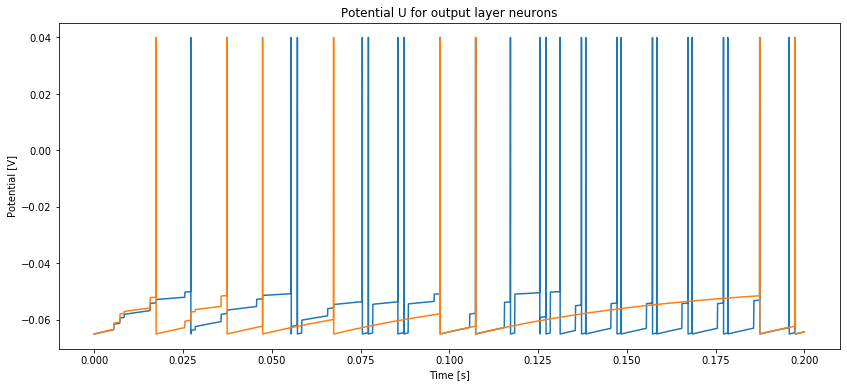

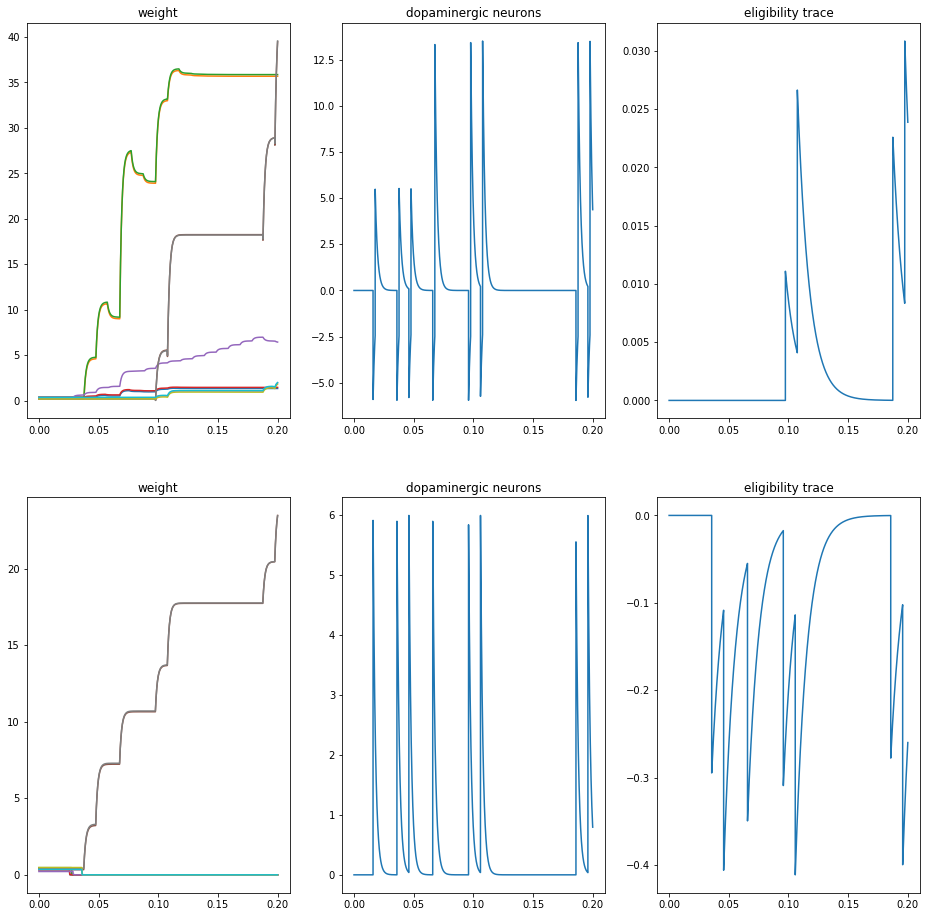

In [62]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

22.829871056238407 8.704385481435756e-11
0.1782302546718691 3.1762245662767996e-11
0.36087036088384583 8.234027354160203e-11
22.74713296829812 5.666372068985097e-12
0.32183417080111404 4.289983968295122e-10
0.32521554015732446 5.601614483662512e-10
66.26561854702774 32.32057091607965
0.3370043808166174 4.83603181643537e-08
66.34558498878255 32.277333566486504
66.58589717451814 32.2178660344004


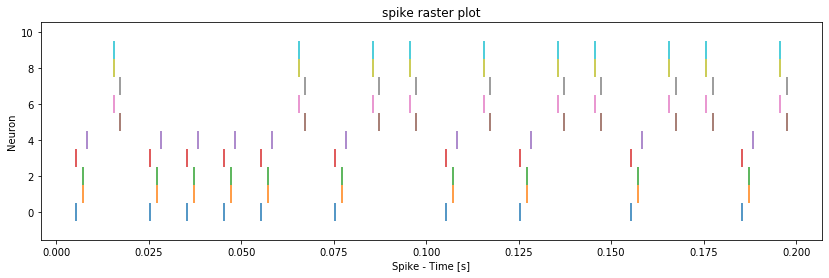

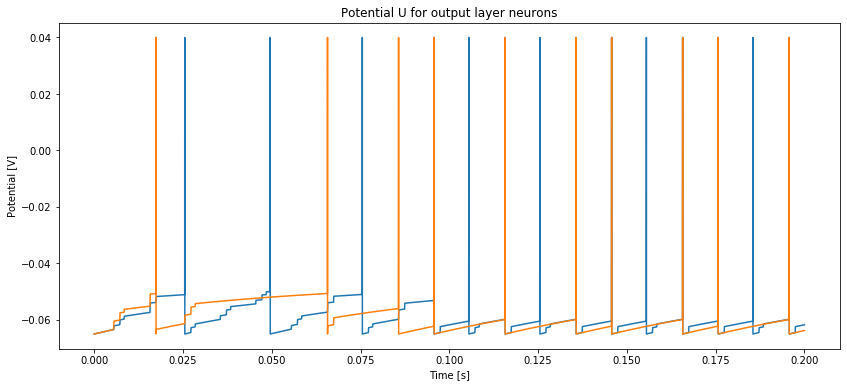

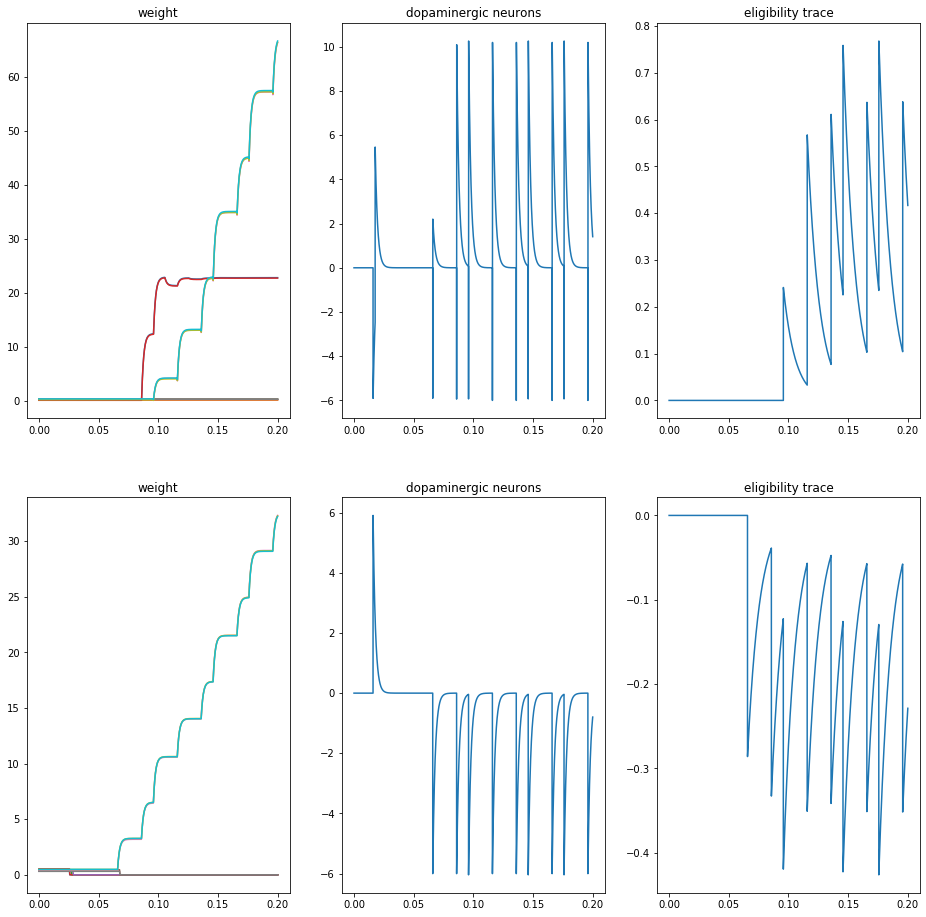

In [64]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

84.74862351833548 44.42699023852583
0.3174280599716711 1.9110570709152077e-11
0.09036962075527824 2.5719862560136597e-12
85.03212208842919 44.05804767201632
0.4452009740662533 1.4769576292772508e-10
0.2333139256877578 2.745260504570137e-24
0.26901923274018186 3.496936099145546e-25
0.3341693000971085 4.717077265338134e-24
0.3098631729086799 8.184319442152302e-25
0.26511029746668446 7.22958031631164e-24


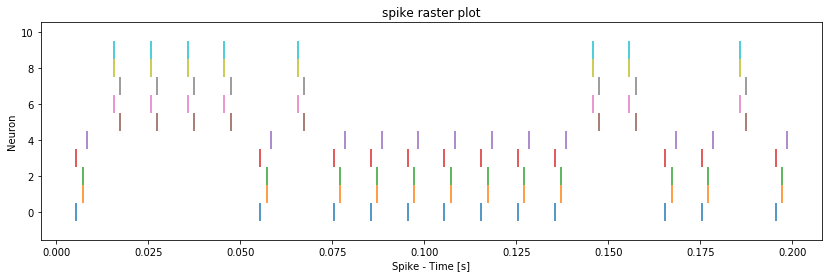

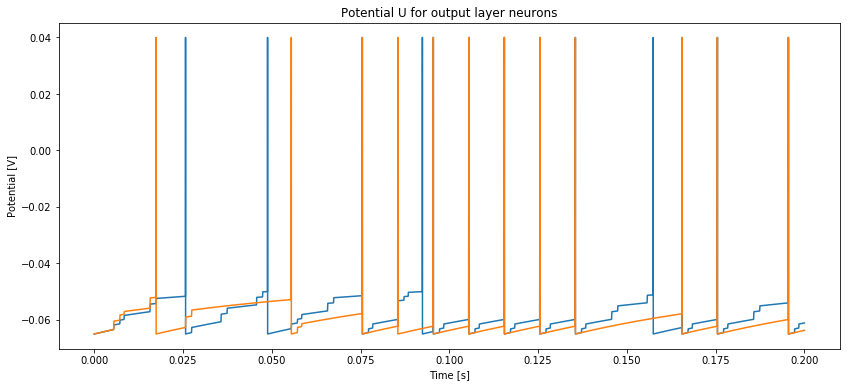

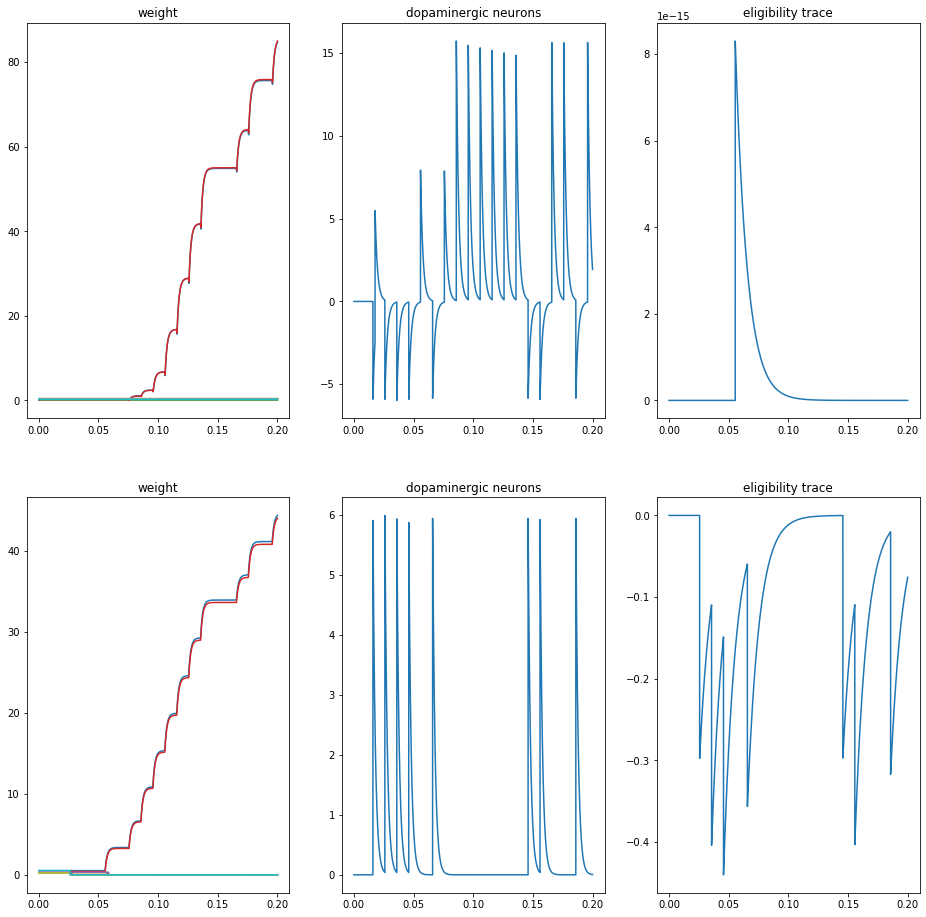

In [65]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

50.61410388355656 5.686217196864012e-13
0.5524831960424236 6.9471943913017e-14
0.6185270741438739 3.7141716481088214e-13
50.49816914145261 1.3621178815601863e-12
0.43626963959426995 1.62628201194256e-13
0.258562963526583 1.9571639095931883e-13
29.80383010513519 25.01338350991478
0.12491867418464067 5.273946297160617e-15
29.840192219291296 25.104064134963583
29.80973336837892 24.87611945398131


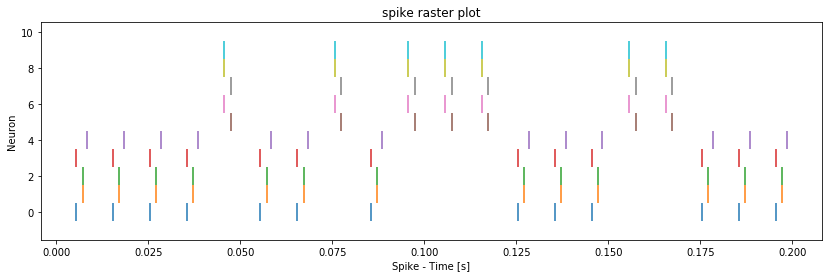

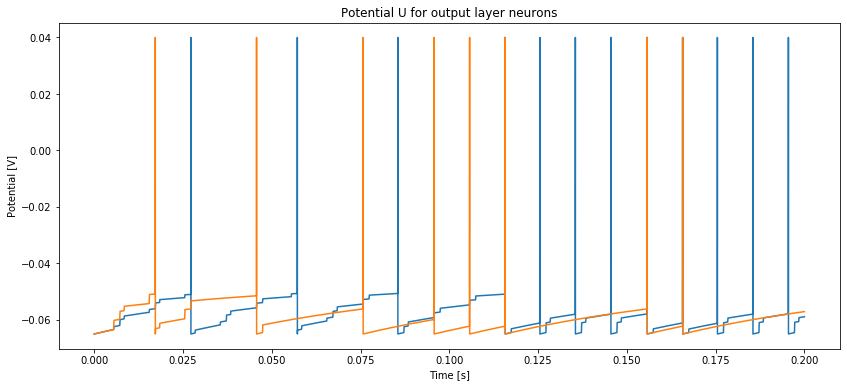

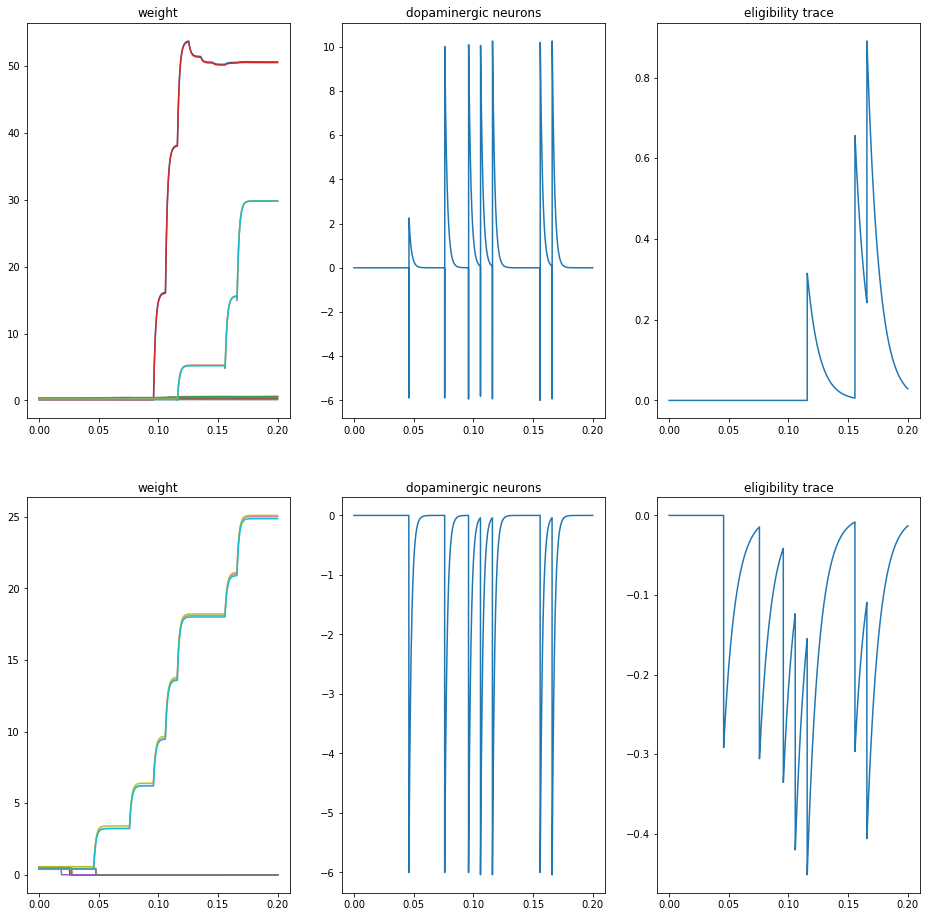

In [76]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

7.374022786495923 3.204277053105184e-23
0.2791058830414228 1.8380972229620666e-24
0.23673470198330862 1.0018194264265823e-23
7.359872381057183 4.6296424904968016e-27
0.38059941468681047 23.29663287846973
0.37900858655961345 6.584947851016572e-11
53.33290836758403 2.9305009680968925e-12
0.377184961347553 1.9924426997092587e-11
53.225315797537995 1.2328256176845863e-13
53.32867311078316 1.4152128771167132e-11


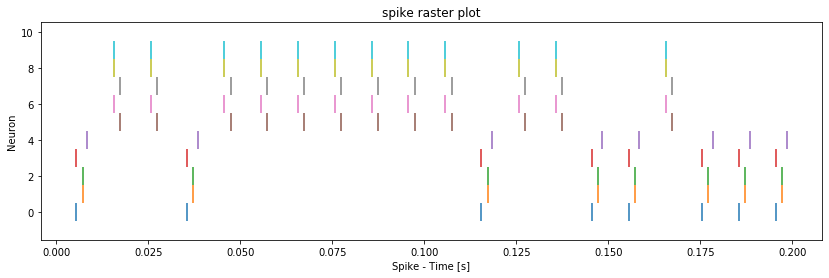

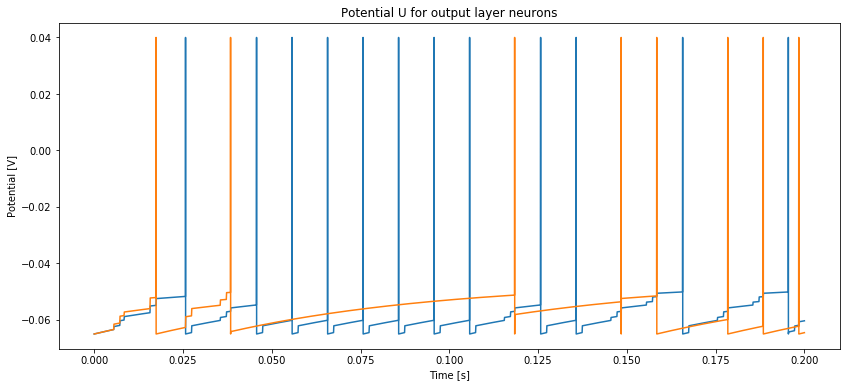

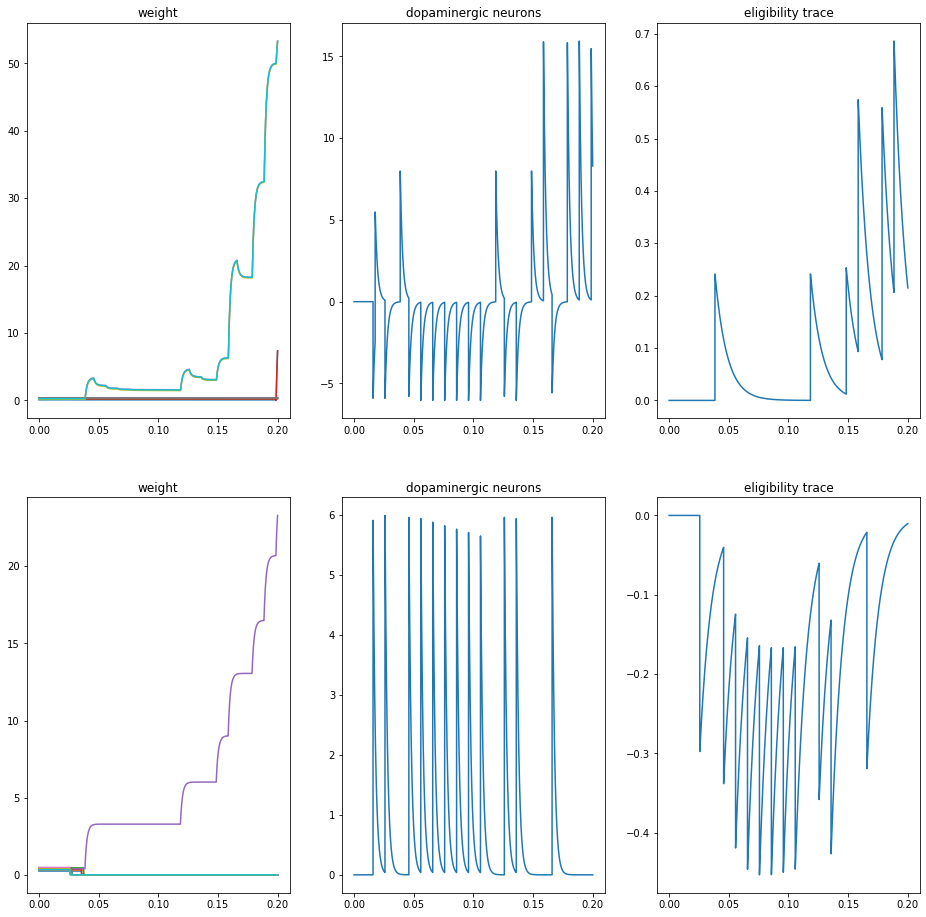

In [84]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.1786668826096596 7.451944415915748e-17
18.30704596467161 1.0133736649572511e-16
18.63184800004198 6.678075696065041e-17
0.15038984420453658 2.307853057611932e-16
0.4990029881944341 3.181579529953593e-16
85.182360331297 35.07936505857101
0.4686293966406438 2.3778300181426643e-18
85.19552231595145 35.05268844960806
0.3141769947057798 1.3440220706977574e-17
0.31098278521067035 3.2694281914596186e-16


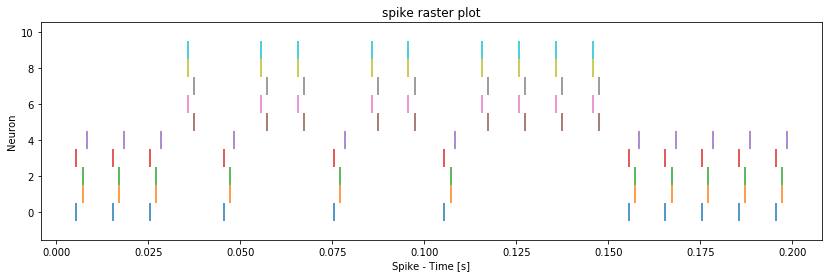

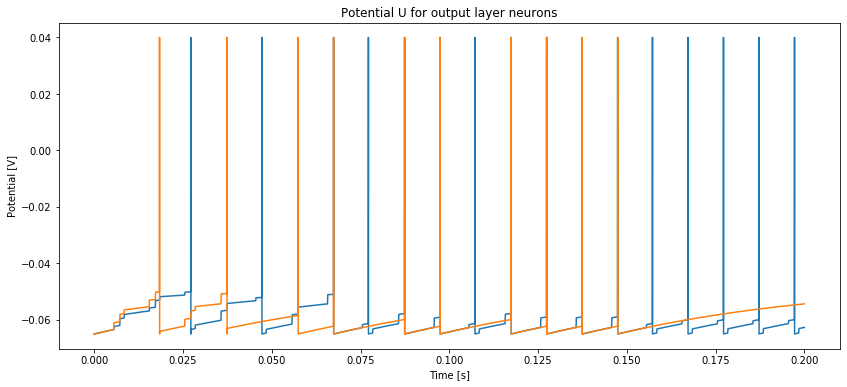

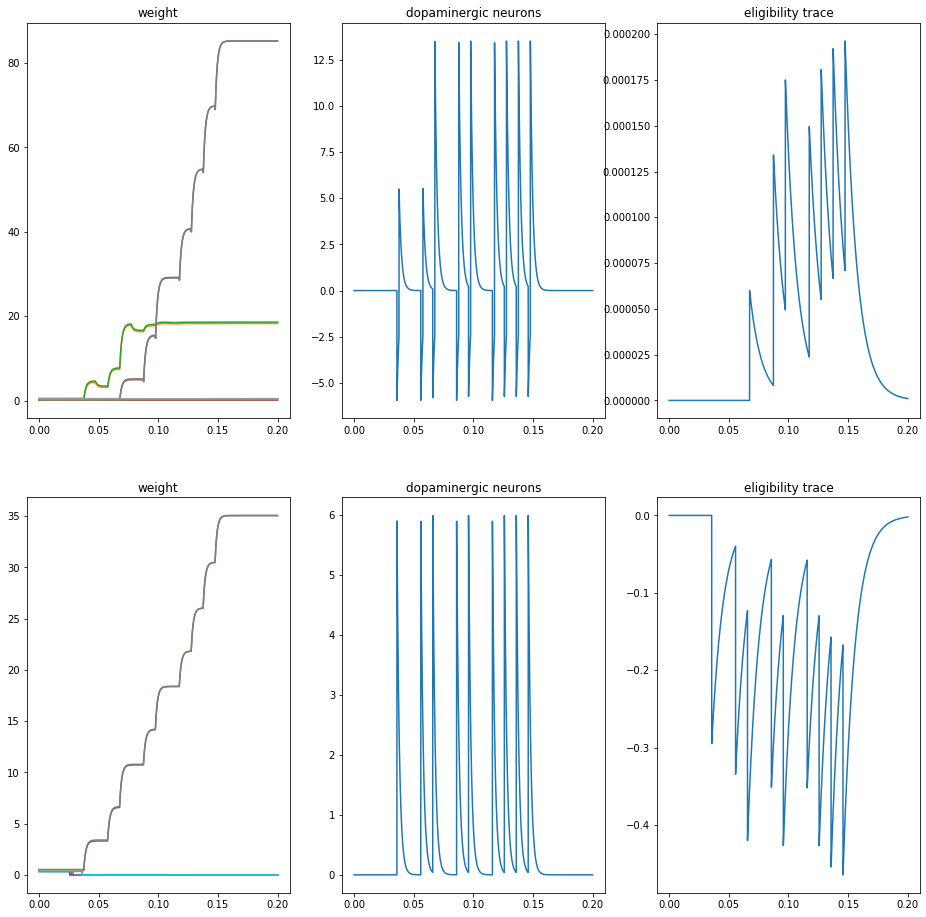

In [86]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

15.376454370475706 2.4414425477479757e-12
0.5189429935869372 4.746828032838102e-11
0.464220508541807 8.005070854108088e-11
15.188508225837769 9.605341343468343e-12
0.29645008214490626 3.3118328936149645e-10
35.159407877586155 19.773039086281408
0.18811333111970452 1.3458770476956657e-12
35.17284105277172 19.479114360843756
0.24554660674818873 1.5887700568319661e-15
0.26874437464504985 1.3216740696531816e-12


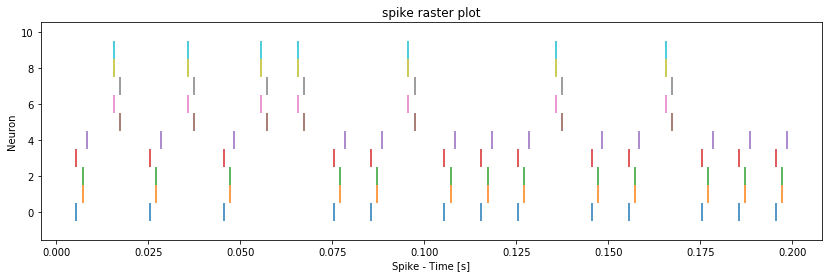

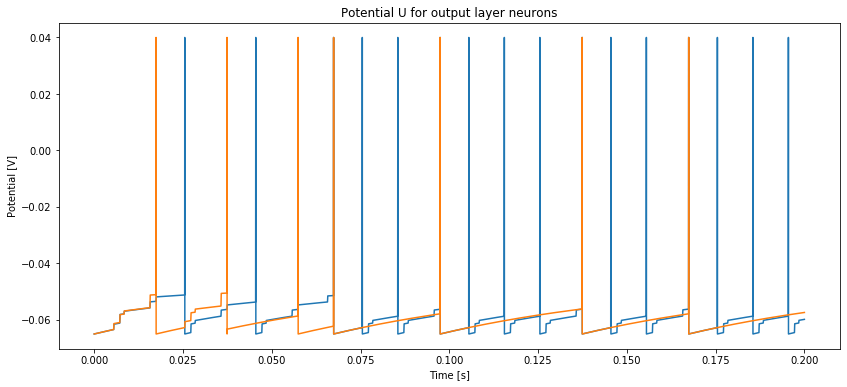

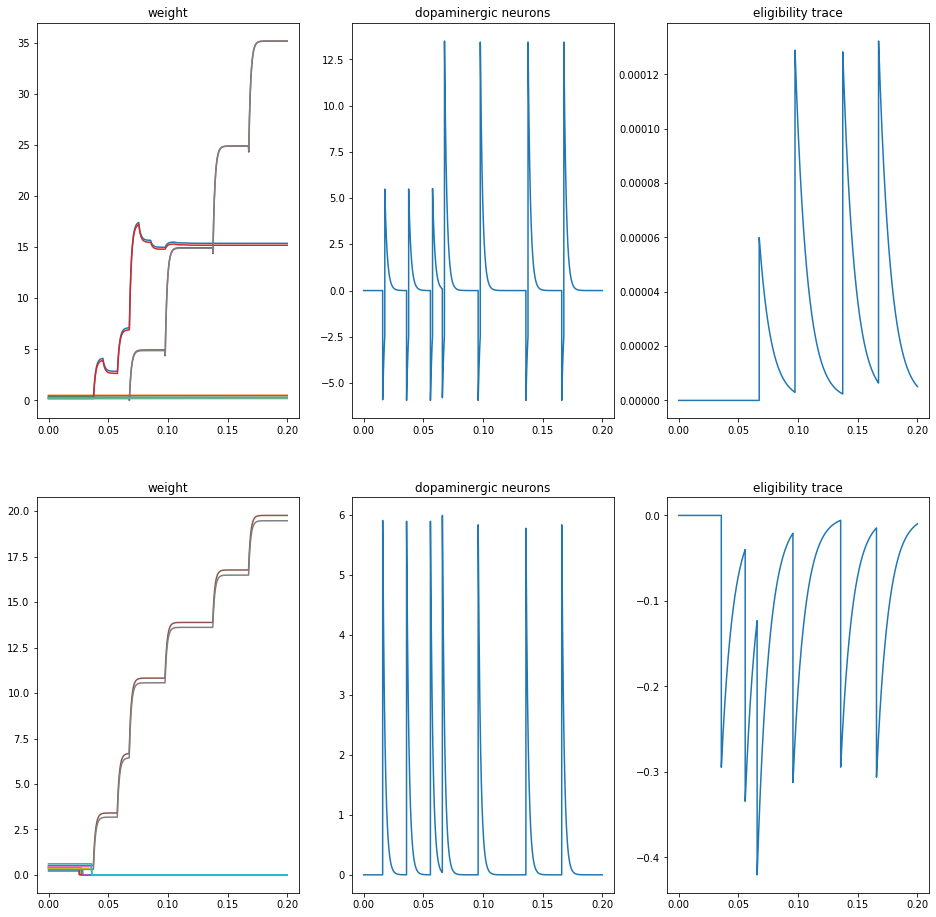

In [87]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.26309113078284363 8.817229762192494e-14
18.045773612663062 3.632304413173288e-14
18.072300671852137 1.3139204944797112e-13
0.1956180735245926 9.3692495299776e-16
0.24088395152355574 6.724899725928556e-13
88.96444728336957 40.45166890657275
0.299830554060631 1.528492830911591e-10
89.28684921811563 40.224565950677366
0.19372053634636932 5.207433769833846e-10
0.5430982331966896 2.5261248756580406e-11


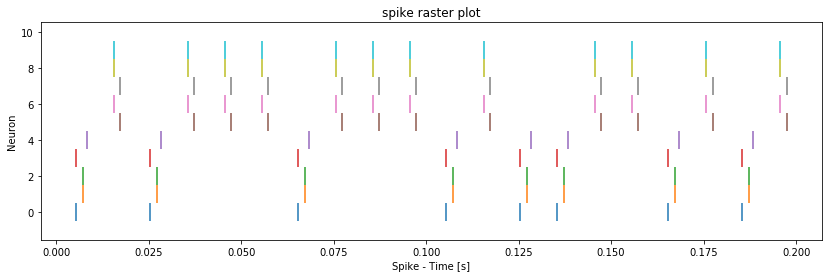

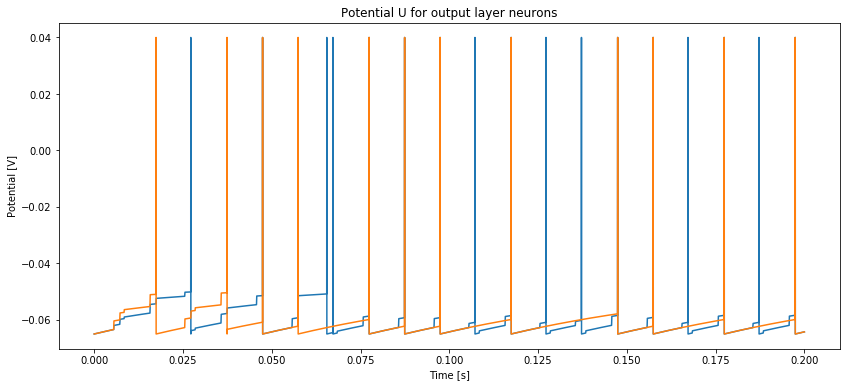

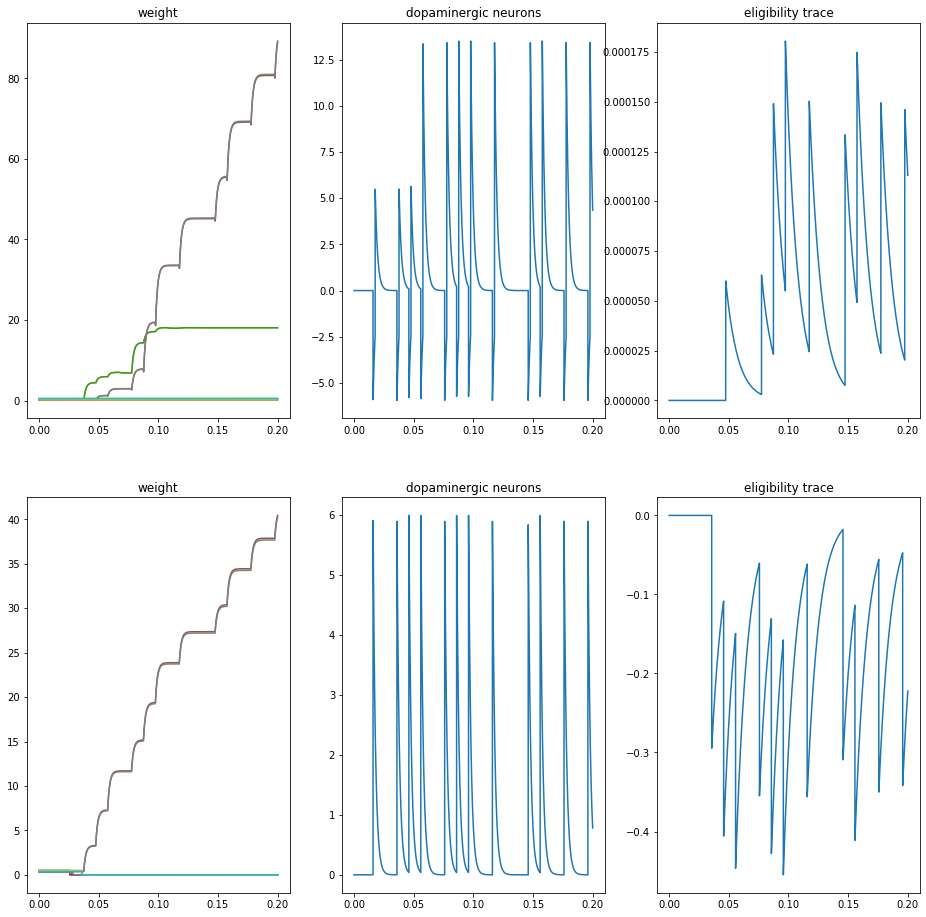

In [89]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.09282575333314758 5.557161087654352e-16
0.37926651211337387 24.677342945250015
0.3411725183318829 24.67388257422696
0.264757590719092 4.982186264949568e-16
0.1538518013477417 2.803584414888995e-15
0.3530436672791898 5.772331748671302e-14
84.55134966573628 3.3213751513760465e-11
0.6332907719881298 1.969176853507739e-12
84.56884253858972 1.8401011768599676e-10
84.68225293549105 2.708389718539645e-12


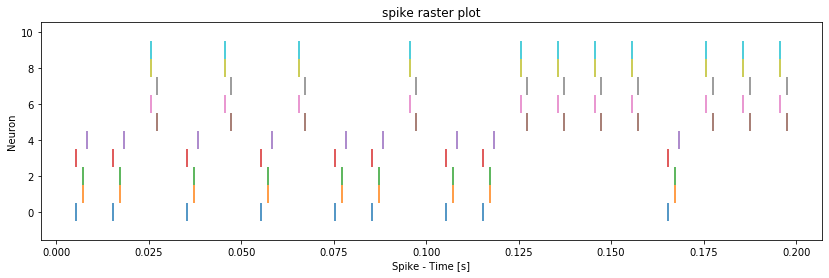

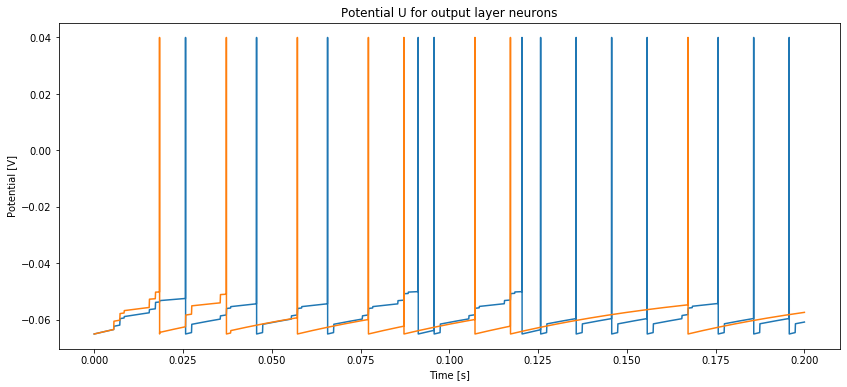

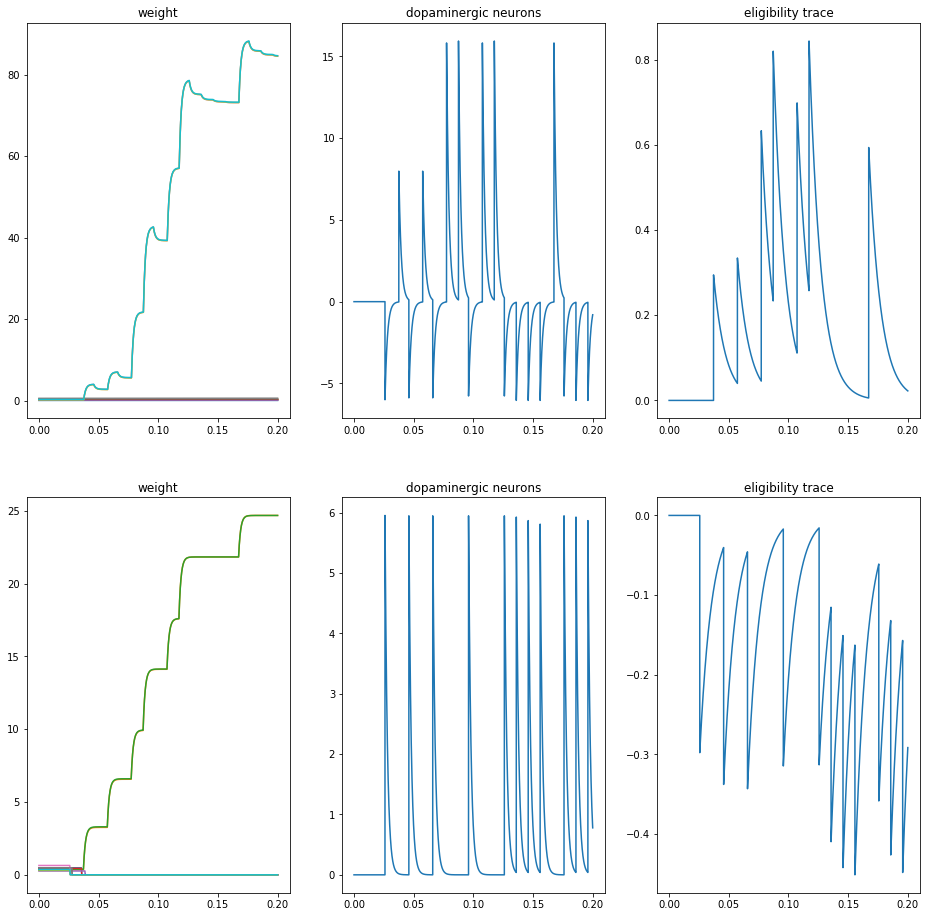

In [91]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

0.47806953653393125 5.947337047397826e-16
19.417563559146405 1.9852330752465446e-15
19.325156171645215 7.736393981468969e-17
0.31149293501667186 1.6234862039895983e-15
0.4776369704231315 1.5002648233457606e-15
0.39621859096494344 4.808657607808179e-16
68.96299482214181 28.80721126240728
0.2659303667321404 2.939515052342748e-17
69.20329377166296 28.73610029531025
69.33490758632541 28.545392149688116


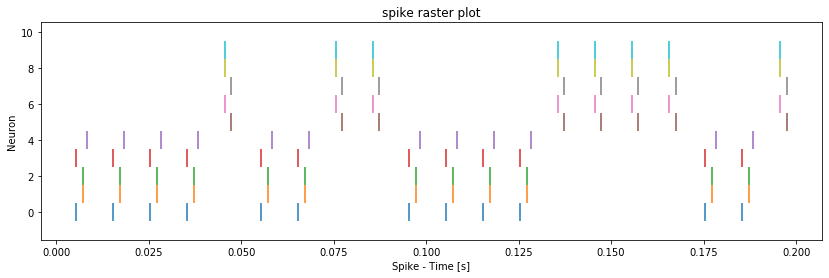

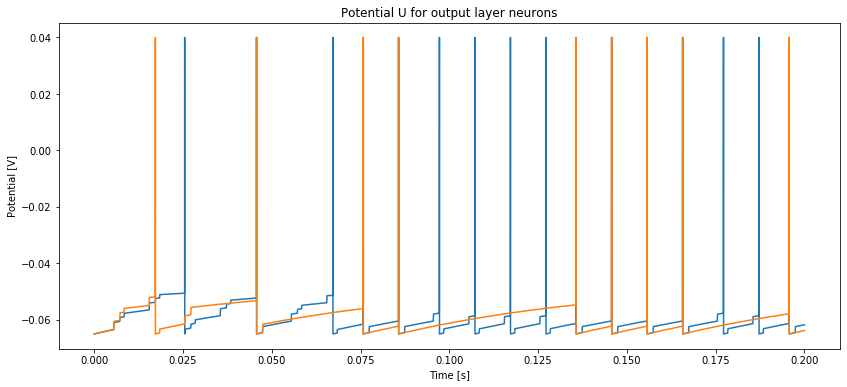

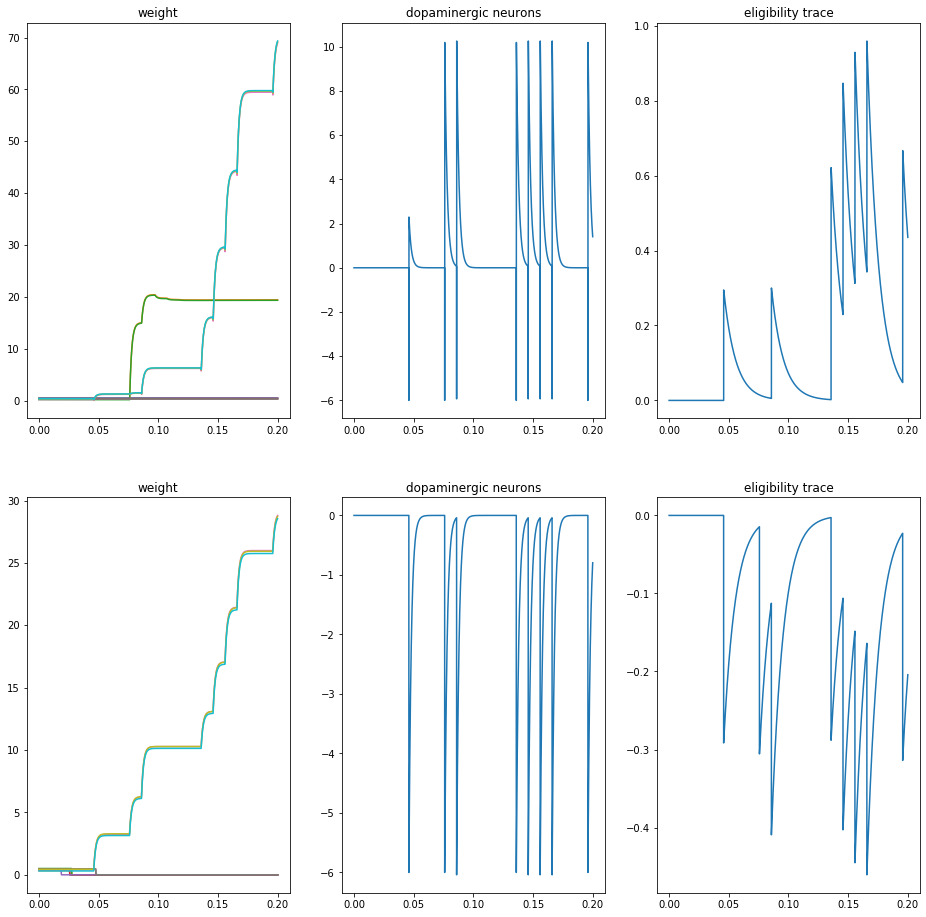

In [16]:
simul_STDP(0.0029 ,0.016,0.001 ,1)

Sharare Zolghadr (610395109)                                                                      
Computational Neuroscience